theta:[ 1.31635295 -0.05128958 -0.57659976  0.42026517  0.03686637]
mse - LINEAR REGRESSOR :0.751636251899054
mse - RANDOM FOREST REGRESSOR :0.02135974611686352
95% Confidence Interval: (0.018324128538007373, 0.021276171370095288)
t-statistic: -2.600511460607196, p-value: 0.018079920360540996


/var/folders/3x/5_xvxgws3bqg82rrxr7z_w3m0000gn/T/ipykernel_31627/2421082711.py:176: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = ttest_ind(mse_scores, [linear_mse] * n_folds)


44/44 [==============================] - 0s 482us/step
mse NN test error:0.016524337651228224
mse NN training error:0.013422903026179591
313/313 [==============================] - 0s 407us/step


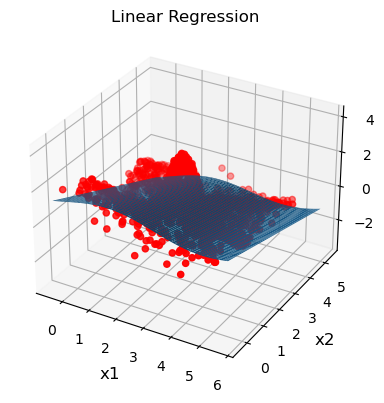

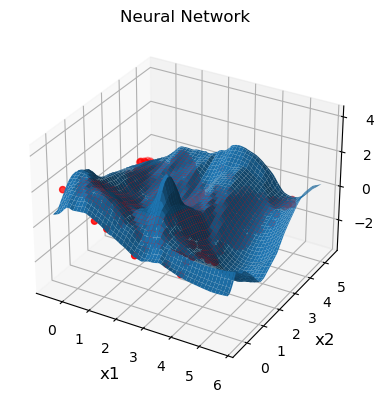

INFO:tensorflow:Assets written to: ram://66f84839-dd1b-40f6-a0dd-a93e2e254116/assets


In [22]:
############# Import libraries #############
import io
import requests
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from tensorflow import keras

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import ttest_ind

import pickle 

#  Loading the data using numpy function
url = 'https://drive.switch.ch/index.php/s/TeDwnbYsBKRuJjv/download'
response = requests.get(url)
data = np.load(io.BytesIO(response.content))

#  x is a Numpy array of shape (n_samples, n_features) with the inputs 
x = data.f.x

#  y is a Numpy array of shape (n_samples, ) with the targets
y = data.f.y

#  The features are processed by adding some additional columns to X using numpy operations.
ones = np.ones(len(x))
x1 = x[:,0]
x2 = x[:,1]
sin_x2 = np.sin(x2)
x1_x2 = x1*x2

X = np.hstack((ones.reshape(-1,1),
              x1.reshape(-1,1),
              x2.reshape(-1,1),
              sin_x2.reshape(-1,1),
              x1_x2.reshape(-1,1)))



#   Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.7, shuffle=True, random_state=0)


#   linear regression model is trained
ols_model = LinearRegression(fit_intercept=False)

Res = ols_model.fit(x_train,y_train)

#   Obtain the coefficients 
theta = ols_model.coef_

y_pred = ols_model.predict(x_test)

mse = mean_squared_error(y_test,y_pred)




#   Print Theta and MSE
print(f"theta:{theta}")
print(f"mse - LINEAR REGRESSOR :{mse}")


#   Create arrays for x1 and x2 equally spaced between min and max
x1_pred = np.linspace(X[:,1].min(), X[:,1].max(), 100)
x2_pred = np.linspace(X[:,2].min(), X[:,2].max(), 100)


#   create a 2d mesh for both x1 and x2
X1_pred, X2_pred = np.meshgrid(x1_pred, x2_pred)

#   flatten the grid for model calculation
x_grid_flatten = np.array([np.ones(X1_pred.flatten().shape),
                           X1_pred.flatten(), X2_pred.flatten(), 
                           np.sin(X1_pred.flatten()),
                           X1_pred.flatten()*X2_pred.flatten()]).T

#   Make prediction using flattened grid
y_pred_grid = Res.predict(x_grid_flatten)

#   Create 3d figure
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(projection='3d')

#   Plot the prediction surface
ax.plot_surface(X1_pred, X2_pred, y_pred_grid.reshape(X1_pred.shape))

#   Plotting the 3D graph
ax.scatter(X[:,1], X[:,2], y, color='r')
ax.set_xlabel('x1', fontsize=12)
ax.set_ylabel('x2', fontsize=12)
ax.set_zlabel('y', fontsize=12)
plt.title("Linear Regression")
fig.tight_layout()
    
#   Save this model into a pickle file
#   To save the trained model as a pickle file
with open('ols_model.pickle', 'wb') as f:
    pickle.dump(ols_model, f)

                          
                     ############# T2 #############

#   x is a Numpy array of shape (n_samples, n_features) with the inputs 
x = data.f.x

#   y is a Numpy array of shape (n_samples, ) with the targets
y = data.f.y


#   Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.7, shuffle=True, random_state=0)

#   Create an instance of the Random Forest regressor with default hyperparameters
fr = RandomForestRegressor()

#   Train the Random Forest regressor on the training data
fr.fit(x_train,y_train)

#   Make predictions
y_pred = fr.predict(x_test)

#   Calculate the mean squared error between the predicted values (y_pred) and the actual values (y_test)
mse = mean_squared_error(y_test,y_pred)

print(f"mse - RANDOM FOREST REGRESSOR :{mse}")



##### Statistical analysis
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import t

# Split the data into K folds using the KFold function:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

mse_scores = []


# Looping through each fold and training the Random Forest model
for train_index, test_index in kfold.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestRegressor()
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)


# Calculating the confidence interval using the t-distribution with n-1 degrees of freedom, where n is the number of folds
    n_folds = len(mse_scores)
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores, ddof=1)
alpha = 0.05
t_critical = t.ppf(1 - alpha / 2, df=n_folds - 1)
ci_lower = mean_mse - t_critical * std_mse / np.sqrt(n_folds)
ci_upper = mean_mse + t_critical * std_mse / np.sqrt(n_folds)
print(f"95% Confidence Interval: ({ci_lower}, {ci_upper})")



# Performing a t-test to compare the mean squared errors of the Random Forest model with the linear regression model
_, linear_mse = Res.predict(x_test), mean_squared_error(y_test, y_pred)
t_statistic, p_value = ttest_ind(mse_scores, [linear_mse] * n_folds)
print(f"t-statistic: {t_statistic}, p-value: {p_value}")

with open('fr.pickle', 'wb') as b:
    pickle.dump(fr, b)


                     ############# T3 #############


# Split data again
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.7, shuffle=True, random_state=0)

#   Define the model architecture
nn_model = keras.Sequential([
    keras.layers.Dense(68, activation='relu'),
    keras.layers.Dense(28, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='linear')
    ])

#  Compile the model with Adam optimizer and Mean Squared Error loss
nn_model.compile(optimizer='adam', loss='mse')

#  Fit the model on the training data
history = nn_model.fit(x_train, y_train, epochs=350, batch_size=40,verbose = 0)

#  Make predictions on the test data
y_pred = nn_model.predict(x_test)
y_pred2 = nn_model.predict(x_train)

#   Calculate the mean squared error between the true target values (y_test) and the predicted target values (y_pred) 
mse = mean_squared_error(y_test,y_pred)
mse_train = mean_squared_error(y_train,y_pred2)

#   Print out the values
print(f"mse NN test error:{mse}")
print(f"mse NN training error:{mse_train}")


# Create 3d figure
y_pred_grid = nn_model.predict(x_grid_flatten)
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(projection='3d')

# Plot the prediction surface
ax.plot_surface(X1_pred, X2_pred, y_pred_grid.reshape(X1_pred.shape))


# Plot again the 3D for FF Neural Network
ax.scatter(X[:,1], X[:,2], y, color='r')
ax.set_xlabel('x1', fontsize=12)
ax.set_ylabel('x2', fontsize=12)
ax.set_zlabel('y', fontsize=12)
plt.title("Neural Network")
fig.tight_layout()
plt.show()

#   Save a pickle
with open('nn_model.pickle', 'wb') as c:
    pickle.dump(nn_model, c)

In [21]:
# Import libraries
import joblib
import io
import requests
import numpy as np

def evaluate_predictions(y_true, y_pred):
    """
    Evaluates the mean squared error between the values in y_true and the values
    in y_pred.
    ### YOU CAN NOT EDIT THIS FUNCTION ###
    :param y_true: Numpy array, the true target values from the test set;
    :param y_pred: Numpy array, the values predicted by your model.
    :return: float, the mean squared error between the two arrays.
    """
    assert y_true.shape == y_pred.shape
    return ((y_true - y_pred) ** 2).mean()


def load_model(filename):
    """
    Loads a Scikit-learn model saved with joblib.dump.
    This is just an example, you can write your own function to load the model.
    Some examples can be found in src/utils.py.
    :param filename: string, path to the file storing the model.
    :return: the model.
    """
    model = joblib.load(filename)

    return model

# Load the data
# This will be replaced with our private test data when grading the assignment

# Load data from url
url = 'https://drive.switch.ch/index.php/s/TeDwnbYsBKRuJjv/download'
response = requests.get(url)
data = np.load(io.BytesIO(response.content))


#############################################################################

# x is a Numpy array of shape (n_samples, n_features) with the inputs
x = data.f.x
# y is a Numpy array of shape (n_samples, ) with the targets
y = data.f.y

ones = np.ones(len(x))
x1 = x[:,0]
x2 = x[:,1]
sin_x2 = np.sin(x2)
x1_x2 = x1*x2

X = np.hstack((ones.reshape(-1,1),
              x1.reshape(-1,1),
              x2.reshape(-1,1),
              sin_x2.reshape(-1,1),
              x1_x2.reshape(-1,1)))

y = y.reshape(-1,1)

#############################################################################

# Load the trained model

baseline_model_L_path = './ols_model.pickle'  # <-- Linear Model
baseline_model_path = './nn_model.pickle'     # <-- FFNN Model
baseline_model = load_model(baseline_model_path)


# Predict on the given samples
y_pred = baseline_model.predict(X)

############################################################################
# STOP EDITABLE SECTION: do not modify anything below this point.
############################################################################

# Evaluate the prediction using MSE
mse = evaluate_predictions(y_pred, y)
print(f'MSE on whole dataset: {mse}')



63/63 [==============================] - 0s 452us/step
MSE on whole dataset: 0.01572671248151978
